In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Data Loading

In [3]:
df_train = pd.read_csv('Data/fraudTrain.csv')
print(df_train.head(3))

   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   

                          merchant       category     amt      first     last  \
0       fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer    Banks   
1  fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie     Gill   
2             fraud_Lind-Buckridge  entertainment  220.11     Edward  Sanchez   

  gender                        street  ...      lat      long  city_pop  \
0      F                561 Perry Cove  ...  36.0788  -81.1781      3495   
1      F  43039 Riley Greens Suite 393  ...  48.8878 -118.2105       149   
2      M      594 White Dale Suite 530  ...  42.1808 -112.2620      4154   

                                 job         dob  \
0          Psychologist, counselling  1988-03-09   
1  Special educational needs teacher 

In [4]:
df_train.isna().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

# Exploratory Data Analysis
## 1. Transaction amount vs Fraud

With the dataset cleaned, we can now start to examine how various features relate to fraud. First we will see how the distrition of transaction amount differs between fraudulent and normal activities.

In [5]:
df_train['amt'].describe()

count    1.296675e+06
mean     7.035104e+01
std      1.603160e+02
min      1.000000e+00
25%      9.650000e+00
50%      4.752000e+01
75%      8.314000e+01
max      2.894890e+04
Name: amt, dtype: float64

In [6]:
np.percentile(df_train['amt'],99)

545.9926000000002

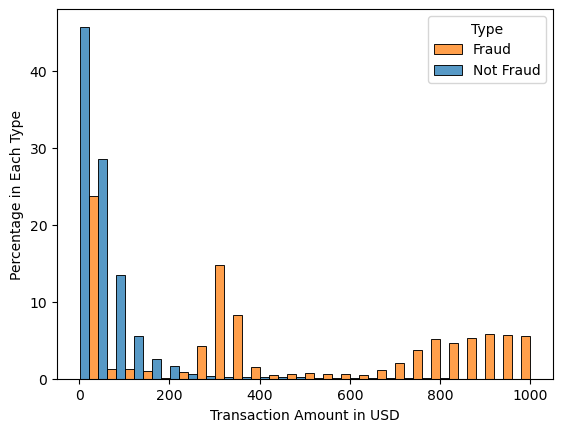

In [7]:
#amount vs fraud
ax=sns.histplot(x='amt',data=df_train[df_train.amt<=1000],hue='is_fraud',stat='percent',multiple='dodge',common_norm=False,bins=25)
ax.set_ylabel('Percentage in Each Type')
ax.set_xlabel('Transaction Amount in USD')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

The result is very interesting! While normal transactions tend to be around 200 or less, we see fraudulent transactions peak around 300 and then at the 800-1000 range. There is a very clear pattern here!

## 2. Gender vs Fraud
Second, we will examine whether one gender is more susceptible to fraud than the other.

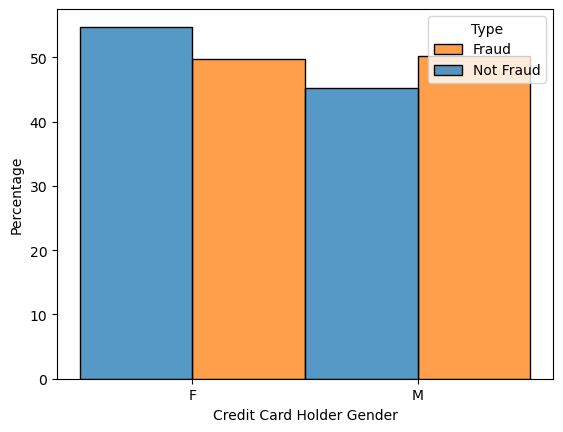

In [8]:
#Gender vs Fraud
ax=sns.histplot(x='gender',data=df_train, hue='is_fraud',stat='percent',multiple='dodge',common_norm=False)
ax.set_ylabel('Percentage')
ax.set_xlabel('Credit Card Holder Gender')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

In this case, we do not see a clear difference between both genders. Data seem to suggest that females and males are almost equally susceptible (50%) to transaction fraud. Gender is not very indicative of a fraudulent transaction.

## 4. Age vs Fraud
Are older people more prone to credit card fraud? Or is it the other way around? Given the birthday info, we can calculate the age of each card owner (in 2023) and see whether a trend exists. 

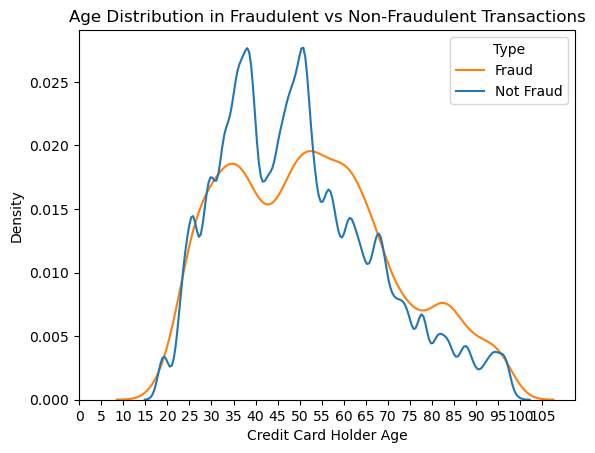

In [9]:
#age vs fraud
import datetime as dt
df_train['age'] = dt.date.today().year-pd.to_datetime(df_train['dob']).dt.year
ax = sns.kdeplot(x='age',data=df_train, hue='is_fraud', common_norm=False)
ax.set_xlabel('Credit Card Holder Age')
ax.set_ylabel('Density')
plt.xticks(np.arange(0,110,5))
plt.title('Age Distribution in Fraudulent vs Non-Fraudulent Transactions')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

The age distribution is visibly different between 2 transaction types. In normal transactions, there are 2 peaks at the age of 37-38 and 49-50, while in fraudulent transactions, the age distribution is a little smoother and the second peak does include a wider age group from 50-65. This does suggest that older people are potentially more prone to fraud.

In [10]:
#splitting trans_date_trans_time into hour, day, month and creating new columns in the data frame

df_train['hour'] = pd.to_datetime(df_train['trans_date_trans_time']).dt.hour
df_train['day'] = pd.to_datetime(df_train['trans_date_trans_time']).dt.dayofweek
df_train['month'] = pd.to_datetime(df_train['trans_date_trans_time']).dt.month

In [11]:
#let us check correlation of features with our target variable, which is is_fraud column

# Checking correlation
correlation = df_train.corr()

print(correlation["is_fraud"].sort_values(ascending=False))

is_fraud      1.000000
amt           0.219404
hour          0.013799
age           0.012378
city_pop      0.002136
lat           0.001894
merch_lat     0.001741
day           0.001739
merch_long    0.001721
long          0.001721
cc_num       -0.000981
zip          -0.002162
Unnamed: 0   -0.004767
unix_time    -0.005078
month        -0.012409
Name: is_fraud, dtype: float64


# Data Modeling and Prediction

The plan is to train the models on the training data set which we have analyzed above and then use the testing dataset to evaluate the model performance.

As data models need numeric input, we need to convert some of our categorical observations into numeric ones. For transaction locations and merchant locations, we already have the longitudinal and latitudinal data. But for shopping categories, we need convert them into dummy variables using pandas.get_dummies.

In [12]:
#subset the training data to include only the features that we need
train = df_train[['category','amt','zip','lat','long','city_pop','merch_lat','merch_long','age','hour',
            'day','month','is_fraud']]

#convert category to dummy variables
train = pd.get_dummies(train, drop_first=True)
y_train = train['is_fraud'].values
X_train = train.drop("is_fraud", axis='columns').values

## Pre-Process Test Data

All the pre_process steps need to be done for test data as well, along with splitting into x and y

In [14]:
#let's do the same to the df_testing dataset
df_test = pd.read_csv('Data/fraudTest.csv')
df_test['age'] = dt.date.today().year-pd.to_datetime(df_test['dob']).dt.year
df_test['hour'] = pd.to_datetime(df_test['trans_date_trans_time']).dt.hour
df_test['day'] = pd.to_datetime(df_test['trans_date_trans_time']).dt.dayofweek
df_test['month'] = pd.to_datetime(df_test['trans_date_trans_time']).dt.month

In [16]:
test = df_test[['category','amt','zip','lat','long','city_pop','merch_lat','merch_long',
             'age','hour','day','month','is_fraud']]
#convert category to dummy variables
test = pd.get_dummies(test, drop_first=True)
y_test = test['is_fraud'].values
X_test = test.drop("is_fraud", axis='columns').values

Now with both datasets cleaned and organized, we can start building models with them. We will first try to use Logistic Regression combined with confusion matrix to evaluate the model.
There is an issue of class imbalance where actual fraud cases are way fewer than normal cases and constitute only a very small part of the dataset. To counter this imbalance, it's important to use the SMOTE (Synthetic Minority Oversampling Technique) method to resample the training dataset so that the model can be trained on more balanced data for better results.

### Logistic Regression

In [18]:
#logistic regression
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

method = SMOTE()
X_resampled, y_resampled = method.fit_resample(X_train, y_train)

model = LogisticRegression()
model.fit(X_resampled,y_resampled)
y_pred = model.predict(X_test)

print('Classification report:\n', classification_report(y_test, y_pred)) 
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97    553574
           1       0.05      0.75      0.10      2145

    accuracy                           0.95    555719
   macro avg       0.53      0.85      0.54    555719
weighted avg       1.00      0.95      0.97    555719

Confusion matrix:
 [[524641  28933]
 [   534   1611]]


Above, the recall is around 0.75 and the general accuracy of the model is around 0.95, which is lower than the actual share of non-fraud cases in the testing dataset. Both metrics seem to suggest that the model does not add very much to detecting fraud. Moreover, the Precision of the model is only 0.05: too many false positives to be actually useful!

### Decision Tree

In [21]:
from sklearn.tree import DecisionTreeClassifier

model2 = DecisionTreeClassifier()
model2.fit(X_resampled,y_resampled)
y_pred = model2.predict(X_test)

print('Classification report:\n', classification_report(y_test, y_pred)) 
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.66      0.78      0.72      2145

    accuracy                           1.00    555719
   macro avg       0.83      0.89      0.86    555719
weighted avg       1.00      1.00      1.00    555719

Confusion matrix:
 [[552718    856]
 [   473   1672]]


In Above, we observe Recall of 0.78  and precision of 0.66. And it has accuracy score of 1.00, even though this is best compared to Logistic Regression, let us check other models, before coming to conclusion.

### Random Forest

In [25]:
#random forest 
from sklearn.ensemble import RandomForestClassifier

In [27]:
model3 = RandomForestClassifier(random_state=5)

In [28]:
model3.fit(X_resampled,y_resampled)

RandomForestClassifier(random_state=5)

In [29]:
y_pred = model3.predict(X_test)

In [30]:
print('Classification report:\n', classification_report(y_test, y_pred)) 
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.88      0.72      0.79      2145

    accuracy                           1.00    555719
   macro avg       0.94      0.86      0.90    555719
weighted avg       1.00      1.00      1.00    555719

Confusion matrix:
 [[553365    209]
 [   593   1552]]


In Above, we observe Recall of 0.72 and precision of 0.88. And it has accuracy score of 1.00, even though this is best compared to Logistic Regression and Decision tree, let us check other models, before coming to conclusion.

In [38]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1296675, 24) (1296675,)
(555719, 24) (555719,)


## Undersampling - Random Undersampling:

- for this, we will use the sample method to randomly choose the total number of data points from majority class as in the minority class.

In [41]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [43]:
#random under sampling using imblearn
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X_train, y_train)

Now, we will do the train-test split with the argument 'stratify' in the method equal to our target variable, in order to have equal number of samples from each class in our split.

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.3, random_state=42, stratify=y_rus)

(4504, 24) (4504,)


Let us Present the data in a better dataframe for good understanding

In [46]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, accuracy_score, f1_score, r2_score
from sklearn.metrics import precision_recall_curve, roc_curve

In [55]:
#evaluating the model
model_name = 'Logistic Regression - Random Under Sampling'
train_score = model1_us.score(X_train,y_train)
test_score = model1_us.score(X_test,y_test)

acc_score = accuracy_score(y_test,y_pred)
f_score = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test,y_pred)

#adding claculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = pd.DataFrame(model_eval_data, columns=['Model Name', 'Training Score', 'Testing Score', 'Accuracy',
                                          'F1 Score', 'Precision', 'Recall'])
evaluate_df

,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - Random Under Sampling,0.854111,0.857904,0.857904,0.856634,0.940919,0.763766


It can be noted from the above dataframe that although the accuracy is less, the precision, F1 score and recall have improved which are much more important metrics to evaluate a classification model.

### Oversampling - Random Over Sampling:

In [57]:
#oversampling with imblearn
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X_train,y_train)

X_train, X_test, y_train, y_test = train_test_split(X_ros,y_ros, test_size=0.3, stratify=y_ros, random_state=42)


In [58]:
#implementing logistic regression
lr = LogisticRegression(random_state=42)
model2_os = lr.fit(X_train, y_train)

y_pred = model2_os.predict(X_test)


In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.96      0.87      1577
           1       0.95      0.75      0.84      1576

    accuracy                           0.86      3153
   macro avg       0.87      0.86      0.86      3153
weighted avg       0.87      0.86      0.86      3153



In [61]:
#evaluating the model
model_name = 'Logistic Regression - Random Over Sampling'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(y_test,y_pred)
f_score = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test,y_pred)
#adding claculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df


,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - Random Under Sampling,0.854111,0.857904,0.857904,0.856634,0.940919,0.763766
1,"[Logistic Regression - Random Over Sampling, 0...",NaN,NaN,NaN,NaN,NaN,NaN
2,Logistic Regression - Random Over Sampling,0.850850,0.856327,0.856644,0.855129,0.948166,0.754442


### Random Over Sampling - Decision Tree

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_rus,y_rus, test_size=0.3, random_state=42)

dtree = DecisionTreeClassifier(max_depth=10)

model = dtree.fit(X_train,y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2232
           1       0.96      0.97      0.97      2272

    accuracy                           0.96      4504
   macro avg       0.96      0.96      0.96      4504
weighted avg       0.96      0.96      0.96      4504



In [64]:
#evaluating the model
model_name = 'Decision Tree - Random Under Sampling'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(y_test,y_pred)
f_score = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test,y_pred)
#adding claculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - Random Under Sampling,0.854111,0.857904,0.857904,0.856634,0.940919,0.763766
1,"[Logistic Regression - Random Over Sampling, 0...",NaN,NaN,NaN,NaN,NaN,NaN
2,Logistic Regression - Random Over Sampling,0.850850,0.856327,0.856644,0.855129,0.948166,0.754442
3,Decision Tree - Random Under Sampling,0.982394,0.964698,0.964698,0.964694,0.958351,0.972271


### Random Over Sampling - Decision Tree

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_ros,y_ros, test_size=0.3, random_state=42)

dtree = DecisionTreeClassifier(max_depth=10)

model = dtree.fit(X_train,y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1579
           1       0.96      0.96      0.96      1574

    accuracy                           0.96      3153
   macro avg       0.96      0.96      0.96      3153
weighted avg       0.96      0.96      0.96      3153



In [76]:
#evaluating the model
model_name = 'Decision Tree - Random Over Sampling'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(y_test,y_pred)
f_score = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test,y_pred)
#adding claculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - Random Under Sampling,0.854111,0.857904,0.857904,0.856634,0.940919,0.763766
1,Logistic Regression - Random Over Sampling,0.850850,0.856327,0.856644,0.855129,0.948166,0.754442
2,Decision Tree - Random Under Sampling,0.982394,0.964698,0.964698,0.964694,0.958351,0.972271
3,Decision Tree - Random Over Sampling,1.000000,0.973579,0.973579,0.973580,0.977384,0.970070
4,Random Forest - Random Under Sampling,1.000000,0.973579,0.973579,0.973580,0.977384,0.970070
5,Random Forest - Random Over Sampling,1.000000,0.965747,0.965747,0.965743,0.974741,0.956163
6,Decision Tree - Random Over Sampling,0.985452,0.960038,0.960038,0.960037,0.962916,0.956798


### Random Under Sampling - Random Forest

In [77]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X_rus,y_rus, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100, criterion='gini')

model = rf.fit(X_train,y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2232
           1       0.98      0.97      0.97      2272

    accuracy                           0.97      4504
   macro avg       0.97      0.97      0.97      4504
weighted avg       0.97      0.97      0.97      4504



In [78]:
#evaluating the model
model_name = 'Random Forest - Random Under Sampling'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(y_test,y_pred)
f_score = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test,y_pred)
#adding claculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - Random Under Sampling,0.854111,0.857904,0.857904,0.856634,0.940919,0.763766
1,Logistic Regression - Random Over Sampling,0.850850,0.856327,0.856644,0.855129,0.948166,0.754442
2,Decision Tree - Random Under Sampling,0.982394,0.964698,0.964698,0.964694,0.958351,0.972271
3,Decision Tree - Random Over Sampling,1.000000,0.973579,0.973579,0.973580,0.977384,0.970070
4,Random Forest - Random Under Sampling,1.000000,0.973579,0.973579,0.973580,0.977384,0.970070
5,Random Forest - Random Over Sampling,1.000000,0.965747,0.965747,0.965743,0.974741,0.956163
6,Decision Tree - Random Over Sampling,0.985452,0.960038,0.960038,0.960037,0.962916,0.956798
7,Random Forest - Random Under Sampling,1.000000,0.972025,0.972025,0.972025,0.977313,0.966989


### Random OVer Sampling - Random Forest

In [79]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X_ros,y_ros, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100, criterion='gini')

model = rf.fit(X_train,y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1579
           1       0.97      0.96      0.97      1574

    accuracy                           0.97      3153
   macro avg       0.97      0.97      0.97      3153
weighted avg       0.97      0.97      0.97      3153



In [80]:
#evaluating the model
model_name = 'Random Forest - Random Over Sampling'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(y_test,y_pred)
f_score = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test,y_pred)
#adding claculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - Random Under Sampling,0.854111,0.857904,0.857904,0.856634,0.940919,0.763766
1,Logistic Regression - Random Over Sampling,0.850850,0.856327,0.856644,0.855129,0.948166,0.754442
2,Decision Tree - Random Under Sampling,0.982394,0.964698,0.964698,0.964694,0.958351,0.972271
3,Decision Tree - Random Over Sampling,1.000000,0.973579,0.973579,0.973580,0.977384,0.970070
4,Random Forest - Random Under Sampling,1.000000,0.973579,0.973579,0.973580,0.977384,0.970070
5,Random Forest - Random Over Sampling,1.000000,0.965747,0.965747,0.965743,0.974741,0.956163
6,Decision Tree - Random Over Sampling,0.985452,0.960038,0.960038,0.960037,0.962916,0.956798
7,Random Forest - Random Under Sampling,1.000000,0.972025,0.972025,0.972025,0.977313,0.966989
8,Random Forest - Random Over Sampling,1.000000,0.965747,0.965747,0.965745,0.971686,0.959339


In [73]:
#dropping some rows, which are of clerical error
evaluate_df = evaluate_df.drop(index=[1,4,5], axis=0)

In [81]:
evaluate_df = evaluate_df.drop(index=[3,4,5], axis=0)

In [82]:
evaluate_df

,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - Random Under Sampling,0.854111,0.857904,0.857904,0.856634,0.940919,0.763766
1,Logistic Regression - Random Over Sampling,0.850850,0.856327,0.856644,0.855129,0.948166,0.754442
2,Decision Tree - Random Under Sampling,0.982394,0.964698,0.964698,0.964694,0.958351,0.972271
6,Decision Tree - Random Over Sampling,0.985452,0.960038,0.960038,0.960037,0.962916,0.956798
7,Random Forest - Random Under Sampling,1.000000,0.972025,0.972025,0.972025,0.977313,0.966989
8,Random Forest - Random Over Sampling,1.000000,0.965747,0.965747,0.965745,0.971686,0.959339


- From the above Dataframe, it can be noted that the Random Forest Algorithm is the best among all the others that we have used for model building.
- Out of all the sampling methods, the random forests method has yielded best results with the random Under sampling sampling algorithm.
